In [65]:
from matplotlib import pyplot as plt
import seaborn as sns
import math
import scipy
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# Узнаем номера моих задач 

In [140]:
from zlib import crc32
import numpy as np

if __name__=='__main__':
    mail = input('enter phystech e-mail\n') 
    to_hash =  mail.strip().split('@')[0]    
    h = crc32(to_hash.encode('utf-8')) + 127
    seed = h%(2**32-1)
    rs = np.random.RandomState(seed)
    task1 = rs.randint(low=1, high=5)
    task2 = rs.randint(low=1, high=5)
    print ('Your tasks are 1.{}, 2.{}'.format(task1, task2))

enter phystech e-mail
ugnivenko.va@phystech.edu
Your tasks are 1.1, 2.2


# Задача 1.1 

Выборка состоит из трех обзектов: X_train, Y_train, X_test

Y_train - изображение (пиксель кодируется черно-белой компонентой изображения), X_train - признаки, соответствующие этому изображению. (элемент X[i,j] соответствует набору признаков для пикселя Y[i,j]).

Требуется:

- Провести отбор наиболее значимых признаков и построить регрессию X->Y
- Проинтерпетировать признаки (каждый признак является функцией, возможно нелинейной, от значения пикселя)
- Получить изображение по X_test (оцениваться будет качество полученного изображения. Ожидается, что регрессия на X_train, Y_train даст R^2>0.85).

In [66]:
regression_x_test = np.load('regression/regression_x_test.npy')
regression_x_train = np.load('regression/regression_x_train.npy')
regression_y_train = np.load('regression/regression_y_train.npy')

In [67]:
invert_dim1 = regression_x_test.shape[0]
invert_dim2 = regression_x_test.shape[1]

## Посмотрим на тестовое изображение 

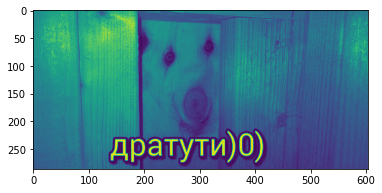

In [68]:
fig, ax = plt.subplots()

ax.imshow(regression_y_train)

fig.set_figwidth(6)   
fig.set_figheight(6)    

plt.show()

# Отберём признаки 

У каждого пикселя 35 признаков 

In [69]:
print(f' Number of features = {regression_x_train.shape[2]}')

 Number of features = 35


Всего пикселей (сэмплов) - 172744

In [70]:
print(f'Number of samples = {regression_x_train.shape[0]*regression_x_train.shape[1]}')

Number of samples = 172744


Посмотрим на вид признаков

In [71]:
binary = []
categorical = []
continuous = []
useless = []
binary_values = {}
for i in range(regression_x_train.shape[2]):
    descr_of_feature = []
    for j in range(regression_x_train.shape[0]):
        for k in range(regression_x_train.shape[1]):
            descr_of_feature.append(regression_x_train[j][k][i])
    if len(set(descr_of_feature)) == 2:
        binary.append(i+1)
        binary_values[i+1] = list(set(descr_of_feature))
    if len(set(descr_of_feature)) > 1000:
        continuous.append(i+1)
    if (len(set(descr_of_feature)) > 2 and len(set(descr_of_feature)) < 1000):
        categorical.append(i+1)
    if len(set(descr_of_feature)) == 1:
        useless.append(i+1)

In [72]:
binary

[1, 2, 3, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [73]:
continuous

[4, 5, 9, 10, 23, 24, 25, 26, 27, 28, 29, 30]

In [74]:
categorical

[]

In [75]:
useless

[31, 32, 33, 34, 35]

In [76]:
binary_values

{1: [0.4967141530112327, 1.4967141530112327],
 2: [-0.13826430117118466, 0.8617356988288154],
 3: [0.6476885381006925, 1.6476885381006925],
 6: [-0.07024108708475416, 0.9297589129152458],
 7: [0.47376384465221744, 1.4737638446522174],
 8: [0.23023041874587263, 1.2302304187458726],
 11: [5.447335223145896, 14.807392350602386],
 12: [40.39050087061236, 14.85883488891553],
 13: [28.87405402738814, 78.4878163765939],
 14: [2617.357151851506, 962.8718863692098],
 15: [98.23639312279403, 36.13914940471159],
 16: [17.174595632318848, 46.68539121846441],
 17: [249.44705306364776, 91.76644248291785],
 18: [237.7859736941728, 87.47657112101957],
 19: [10.612537798017986, 28.84786865018706],
 20: [61.46424059746372, 167.07712831612037],
 21: [491.99726295750435, 180.99567815468586],
 22: [208.23441716949512, 76.60516102097486]}

Признаки 31, 32, 33, 34, 35 - одинаковы для всех писелей, значит не несут смысла.

Преобразуем array -> DataFrame

In [77]:
regression_x_train = np.reshape(regression_x_train,
                                (regression_x_train.shape[0]*regression_x_train.shape[1],
                                 regression_x_train.shape[2]))
regression_y_train = np.reshape(regression_y_train,
                                (regression_y_train.shape[0]*regression_y_train.shape[1],
                                ))
regression_x_test = np.reshape(regression_x_test,
                                (regression_x_test.shape[0]*regression_x_test.shape[1],
                                 regression_x_test.shape[2]))

train_X = pd.DataFrame(regression_x_train, columns = [i for i in range(1,36)])
train_Y = pd.DataFrame(regression_y_train)
test_X = pd.DataFrame(regression_x_test, columns = [i for i in range(1,36)])

Теперь всё в привычном виде

In [78]:
train_X.shape

(172744, 35)

In [79]:
train_Y.shape

(172744, 1)

Добавим константу для линейной регрессии (в GLM добавляется автоматически, а в OLS нет)

In [80]:
train_X['bias'] = 1
test_X['bias'] = 1

### Простроим простую линейную регрессию, ничего не меняя  - Model0

In [81]:
model0 = OLS(train_Y ,train_X).fit()
model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      0   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                 6.157e+04
Date:                Fri, 15 May 2020   Prob (F-statistic):               0.00
Time:                        11:51:15   Log-Likelihood:             2.2548e+05
No. Observations:              172744   AIC:                        -4.509e+05
Df Residuals:                  172737   BIC:                        -4.509e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
1          -1.722e-07   4.71e-10   -365.889      0.000   -1.73e-07   -1.71e-07
2           1.823e-06   5.36e-09    340.454      0.000    1.81e-06    1.83e-06
3           2.797e-06   4.39e-09    636.411      0.000    2.79e-06    2.81e-06
4              0.0160      0.000     42.012      0.000       0.015       0.017
5              0.0133      0.000     35.243      0.000       0.013       0.014
6          -1.429e-06   2.68e-09   -533.443      0.000   -1.43e-06   -1.42e-06
7            3.18e-06   7.59e-09    419.135      0.000    3.17e-06     3.2e-06
8           1.871e-06   3.18e-09    589.149      0.000    1.87e-06    1.88e-06
9              0.0160      0.000     42.002      0.000       0.015       0.017
10             0.0133      0.000     35.245      0.000       0.013       0.014
11          1.581e-07   2.02e-09     78.291      0.000    1.54e-07    1.62e-07
12          4.313e-07   5.51e-09     78.291      0.000     4.2e-07    4.42e-07
13          8.381e-07   1.07e-08     78.291      0.000    8.17e-07    8.59e-07
14          2.795e-05   3.57e-07     78.291      0.000    2.72e-05    2.86e-05
15             0.0002   4.96e-07    427.850      0.000       0.000       0.000
16             0.0001   2.36e-07    427.850      0.000       0.000       0.000
17             0.0005   1.26e-06    427.850      0.000       0.001       0.001
18             0.0005    1.2e-06    427.850      0.000       0.001       0.001
19          4.835e-05   7.63e-08    633.760      0.000    4.82e-05    4.85e-05
20             0.0003   4.42e-07    633.760      0.000       0.000       0.000
21             0.0008    1.3e-06    633.760      0.000       0.001       0.001
22             0.0003   5.51e-07    633.760      0.000       0.000       0.000
23         -1.426e-06   5.32e-08    -26.782      0.000   -1.53e-06   -1.32e-06
24         -2.968e-05   1.11e-06    -26.782      0.000   -3.19e-05   -2.75e-05
25         -2.154e-05   8.04e-07    -26.782      0.000   -2.31e-05      -2e-05
26         -3.056e-05   1.14e-06    -26.782      0.000   -3.28e-05   -2.83e-05
27         -7.392e-06   2.69e-07    -27.459      0.000   -7.92e-06   -6.86e-06
28         -6.281e-06   2.29e-07    -27.459      0.000   -6.73e-06   -5.83e-06
29         -2.392e-05   8.71e-07    -27.459      0.000   -2.56e-05   -2.22e-05
30         -4.091e-05   1.49e-06    -27.459      0.000   -4.38e-05    -3.8e-05
31         -1.334e-06   2.38e-09   -560.112      0.000   -1.34e-06   -1.33e-06
32          4.107e-06   7.33e-09    560.112      0.000    4.09e-06    4.12e-06
33         -2.993e-08   5.34e-11   -560.112      0.000      -3e-08   -2.98e-08
34         -2.345e-06   4.19e-09   -560.112      0.000   -2.35e-06   -2.34e-06
35          1.824e-06   3.26e-09    560.112      0.000    1.82e-06    1.83e-06
bias        2.217e-06   3.96e-09    560.112      0.000    2.21e-06    2.22e-06
==

Как видно, сделать отбор признаков с помощью значения p_value не удастся

### Ладно, давайте будем  действовать методом Forward Elimination

Для предварительного отбора признаков построим одномерные модели по каждому фактору и оценим их значимость:

In [82]:
data = pd.DataFrame()
for column in train_X.columns[:-1]:
    data['feature_'+str(column)] = train_X[column]
data['bias'] = train_X['bias']
data['target'] = train_Y[0]

In [84]:
import statsmodels.api as sm
predictors = list(data.columns)
predictors.remove('target')
predictors.remove('bias')

for p in predictors:
    model_ = sm.GLM.from_formula('target~'+str(p), data=data).fit()
    print (model_.summary2())

                Results: Generalized linear model
Model:              GLM              AIC:            -289045.1003 
Link Function:      identity         BIC:            -2081295.8308
Dependent Variable: target           Log-Likelihood: 1.4452e+05   
Date:               2020-05-15 11:51 LL-Null:        1.2471e+05   
No. Observations:   172744           Deviance:       1897.7       
Df Model:           1                Pearson chi2:   1.90e+03     
Df Residuals:       172742           Scale:          0.010986     
Method:             IRLS                                          
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Intercept     0.7328    0.0007  1063.8385  0.0000   0.7314   0.7341
feature_1    -0.2341    0.0012  -199.0608  0.0000  -0.2364  -0.2318

                Results: Generalized linear model
Model:              GLM

                Results: Generalized linear model
Model:              GLM              AIC:            -261240.2234 
Link Function:      identity         BIC:            -2080964.4166
Dependent Variable: target           Log-Likelihood: 1.3062e+05   
Date:               2020-05-15 11:51 LL-Null:        1.2660e+05   
No. Observations:   172744           Deviance:       2229.1       
Df Model:           1                Pearson chi2:   2.23e+03     
Df Residuals:       172742           Scale:          0.012904     
Method:             IRLS                                          
--------------------------------------------------------------------
            Coef.    Std.Err.       z       P>|z|    [0.025   0.975]
--------------------------------------------------------------------
Intercept   0.5719     0.0005   1242.7936   0.0000   0.5710   0.5728
feature_9   0.0539     0.0006     89.7316   0.0000   0.0527   0.0551

                Results: Generalized linear model
Model:            

                Results: Generalized linear model
Model:              GLM              AIC:            -326574.4657 
Link Function:      identity         BIC:            -2081666.4075
Dependent Variable: target           Log-Likelihood: 1.6329e+05   
Date:               2020-05-15 11:51 LL-Null:        1.1771e+05   
No. Observations:   172744           Deviance:       1527.1       
Df Model:           1                Pearson chi2:   1.53e+03     
Df Residuals:       172742           Scale:          0.0088406    
Method:             IRLS                                          
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Intercept     0.7509    0.0005  1408.7377  0.0000   0.7498   0.7519
feature_17   -0.0009    0.0000  -301.9242  0.0000  -0.0009  -0.0009

                Results: Generalized linear model
Model:              GLM

                Results: Generalized linear model
Model:              GLM              AIC:            -253370.7570 
Link Function:      identity         BIC:            -2080860.5183
Dependent Variable: target           Log-Likelihood: 1.2669e+05   
Date:               2020-05-15 11:51 LL-Null:        1.2669e+05   
No. Observations:   172744           Deviance:       2333.0       
Df Model:           1                Pearson chi2:   2.33e+03     
Df Residuals:       172742           Scale:          0.013506     
Method:             IRLS                                          
-------------------------------------------------------------------
               Coef.   Std.Err.      z      P>|z|    [0.025  0.975]
-------------------------------------------------------------------
Intercept      0.6049    0.0005  1307.2356  0.0000   0.6040  0.6059
feature_25     0.0000    0.0000     0.6018  0.5473  -0.0000  0.0000

                Results: Generalized linear model
Model:              GLM

                Results: Generalized linear model
Model:              GLM              AIC:            -253372.3948 
Link Function:      identity         BIC:            -2080872.5730
Dependent Variable: target           Log-Likelihood: 1.2669e+05   
Date:               2020-05-15 11:51 LL-Null:        1.2669e+05   
No. Observations:   172744           Deviance:       2333.0       
Df Model:           0                Pearson chi2:   2.33e+03     
Df Residuals:       172743           Scale:          0.013506     
Method:             IRLS                                          
-------------------------------------------------------------------
             Coef.   Std.Err.      z       P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Intercept    0.6051    0.0003   2164.2899  0.0000   0.6045   0.6056
feature_33  -0.0082    0.0000  -2164.2899  0.0000  -0.0082  -0.0082

                              Results: Generalized linear model
Model:   

Значимыми признаками являются 

In [85]:
important_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 29, 30, 33]

Многомерная модель со всеми значимыми предикторами:

In [86]:
feat_names = ['feature_' + str(f) for f in important_features]
formula_fe = ' '.join(['target ~', 
                    ' + '.join([f for f in feat_names])])
model_fe = sm.GLM.from_formula(formula_fe, data=data).fit()
model_fe.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Generalized linear model
======================================================================================
Model:                      GLM                    AIC:                  -450229.1710 
Link Function:              identity               BIC:                  -2082398.8981
Dependent Variable:         target                 Log-Likelihood:       2.2512e+05   
Date:                       2020-05-15 11:52       LL-Null:              41530.       
No. Observations:           172744                 Deviance:             746.42       
Df Model:                   5                      Pearson chi2:         746.         
Df Residuals:               172738                 Scale:                0.0043211    
Method:                     IRLS                                                      
--------------------------------------------------------------------------------------
               Coef.         Std.Err.       z    P>|z|       [0.025         0.975]    
--------------------------------------------------------------------------------------
Intercept      42714.9916     48322.4637  0.8840 0.3767     -51995.2969    137425.2800
feature_1      69109.2349     78181.6493  0.8840 0.3767     -84123.9821    222342.4518
feature_2     190270.5807    215248.6256  0.8840 0.3767    -231608.9731    612150.1346
feature_3     542357.5006    613556.2636  0.8840 0.3767    -660190.6784   1744905.6797
feature_4      18607.9375     21050.7133  0.8840 0.3767     -22650.7024     59866.5774
feature_5      -3886.7418      4396.9945 -0.8840 0.3767     -12504.6928      4731.2091
feature_6     -34582.4526     39122.3139 -0.8840 0.3767    -111260.7788     42095.8736
feature_7      36573.3104     41374.5244  0.8840 0.3767     -44519.2674    117665.8881
feature_8     544589.1092    616080.8297  0.8840 0.3767    -662907.1286   1752085.3469
feature_9     -18607.9233     21050.7133 -0.8840 0.3767     -59866.5632     22650.7166
feature_10      3886.7685      4396.9946  0.8840 0.3767      -4731.1825     12504.7194
feature_11    196179.1700    221932.8734  0.8840 0.3767    -238801.2689    631159.6090
feature_12   -109489.5851    123862.9882 -0.8840 0.3767    -352256.5810    133277.4109
feature_13  -2461754.6489   2784925.0401 -0.8840 0.3767   -7920107.4272   2996598.1294
feature_14     74425.7074     84196.0494  0.8840 0.3767     -90595.5171    239446.9318
feature_15   6519017.4439   7374810.8584  0.8840 0.3767   -7935346.2315  20973381.1192
feature_16  -1451876.9372   1642474.1758 -0.8840 0.3767   -4671067.1673   1767313.2928
feature_17  -6702456.4909   7582331.1318 -0.8840 0.3767  -21563552.4281   8158639.4463
feature_18   4621988.0748   5228746.2233  0.8840 0.3767   -5626166.2071  14870142.3568
feature_19   2105647.6619   2382069.5949  0.8840 0.3767   -2563122.9527   6774418.2765
feature_20 104424968.9570 118133507.3289  0.8840 0.3767 -127112450.7750 335962388.6890
feature_21 -39786400.5132  45009417.6103 -0.8840 0.3767 -128003237.9944  48430436.9681
feature_22   9918779.8475  11220881.9737  0.8840 0.3767  -12073744.6957  31911304.3907
feature_27    820666.9583    928401.1966  0.8840 0.3767    -998965.9502   2640299.8667
feature_28    921079.6710   1041995.7330  0.8840 0.3767   -1121194.4377   2963353.7797
feature_29   1012149.1938   1145020.5387  0.8840 0.3767   -1232049.8236   3256348.2113
feature_30   -881516.4486    997238.7914 -0.8840 0.3767   -2836068.5638   1073035.6666
feature_33     -3852.6052      4358.3615 -0.8840 0.3767     -12394.8369      4689.6264
======================================================================================

"""

In [88]:
for_wald_test = ''
for feature in feat_names:
    for_wald_test += feature + '='
model_fe.wald_test(for_wald_test+'0')

/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 27, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[0.7813804]], p-value=0.3767192965896319, df_denom=1>

Короче, этот способ тоже не для нас

### Тогда давайте анализировать

Удалим бесполезные признаки из списка useless

In [90]:
train_X = train_X.drop(columns=[31, 32, 33, 34, 35])
test_X = test_X.drop(columns=[31, 32, 33, 34, 35])

Значения бинарных признаков заменим на 0 и 1

In [91]:
for feature in binary_values.keys():
    train_X[feature] = train_X[feature].apply(lambda x: 0 if x == binary_values[feature][0] else 1)
    test_X[feature] = test_X[feature].apply(lambda x: 0 if x == binary_values[feature][0] else 1)

In [92]:
train_X

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,bias
0,0,0,1,2.288549,0.859431,0,0,1,0.624677,1.256353,...,0,6.467641,134.644964,97.718728,138.643103,45.607623,38.750030,147.605407,252.427767,1
1,0,0,1,2.293655,-0.079660,0,0,1,0.629783,0.317261,...,0,6.500748,135.334184,98.218930,139.352788,17.831804,15.150602,57.711200,98.694957,1
2,0,0,1,2.296195,1.243614,0,0,1,0.632323,1.640535,...,0,6.517282,135.678401,98.468746,139.707226,66.970839,56.901059,216.745739,370.668282,1
3,0,0,1,2.296195,0.714635,0,0,1,0.632323,1.111556,...,0,6.517282,135.678401,98.468746,139.707226,39.459637,33.526459,127.707943,218.400068,1
4,0,0,1,2.288549,0.422087,0,0,1,0.624677,0.819008,...,0,6.467641,134.644964,97.718728,138.643103,29.451076,25.022793,95.316041,163.004973,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172739,0,1,0,2.564834,-0.154069,0,1,0,0.900962,0.242853,...,1,8.525799,177.492207,128.815160,182.762649,16.553125,14.064186,53.572860,91.617764,1
172740,0,1,0,1.774296,-0.147272,0,1,0,0.110424,0.249650,...,1,3.867308,80.510588,58.430646,82.901264,16.666021,14.160107,53.938237,92.242616,1
172741,0,1,0,2.456121,-0.147798,0,1,0,0.792249,0.249123,...,1,7.647535,159.208294,115.545591,163.935814,16.657252,14.152656,53.909857,92.194081,1
172742,0,1,0,1.892871,-0.145478,0,1,0,0.228999,0.251444,...,1,4.354166,90.646120,65.786519,93.337760,16.695945,14.185531,54.035083,92.408236,1


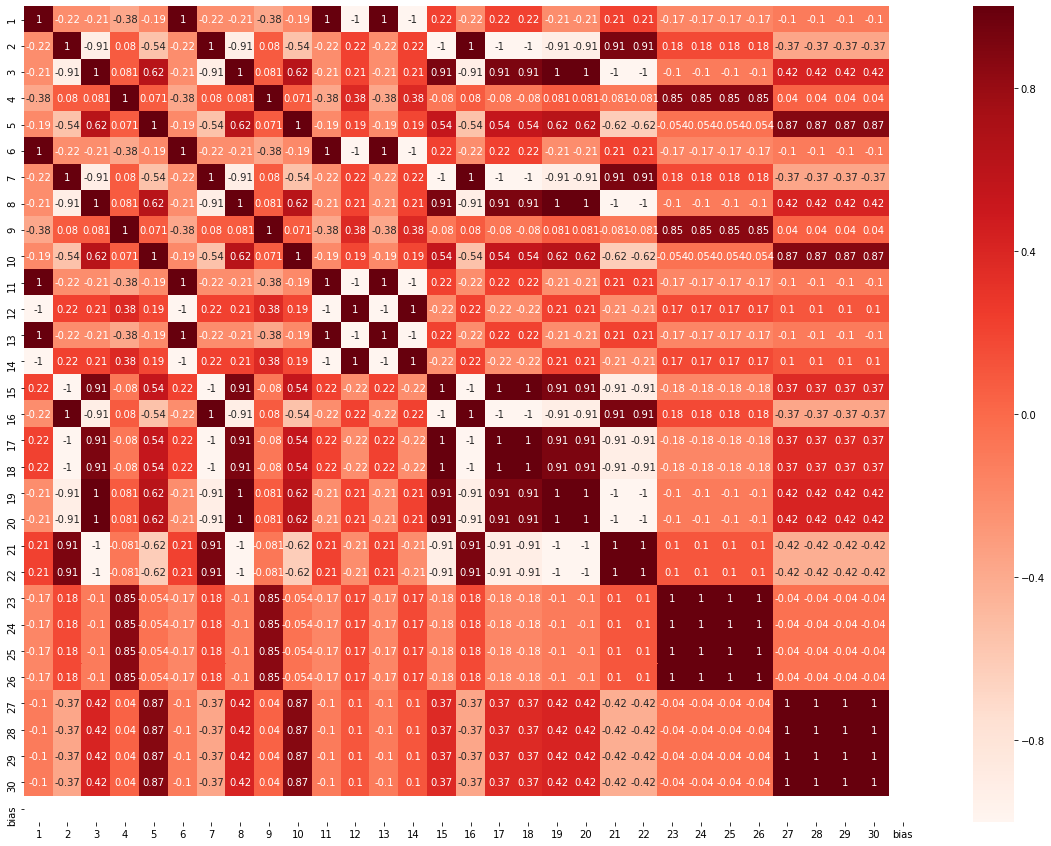

In [93]:
plt.figure(figsize=(20,15))
corr = train_X.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

Почистим группы попарно-коррелирующих признаков 

In [94]:
need = [1,2,3,4,5,23,27,'bias']

In [95]:
train_X = train_X[need]
test_X = test_X[need]

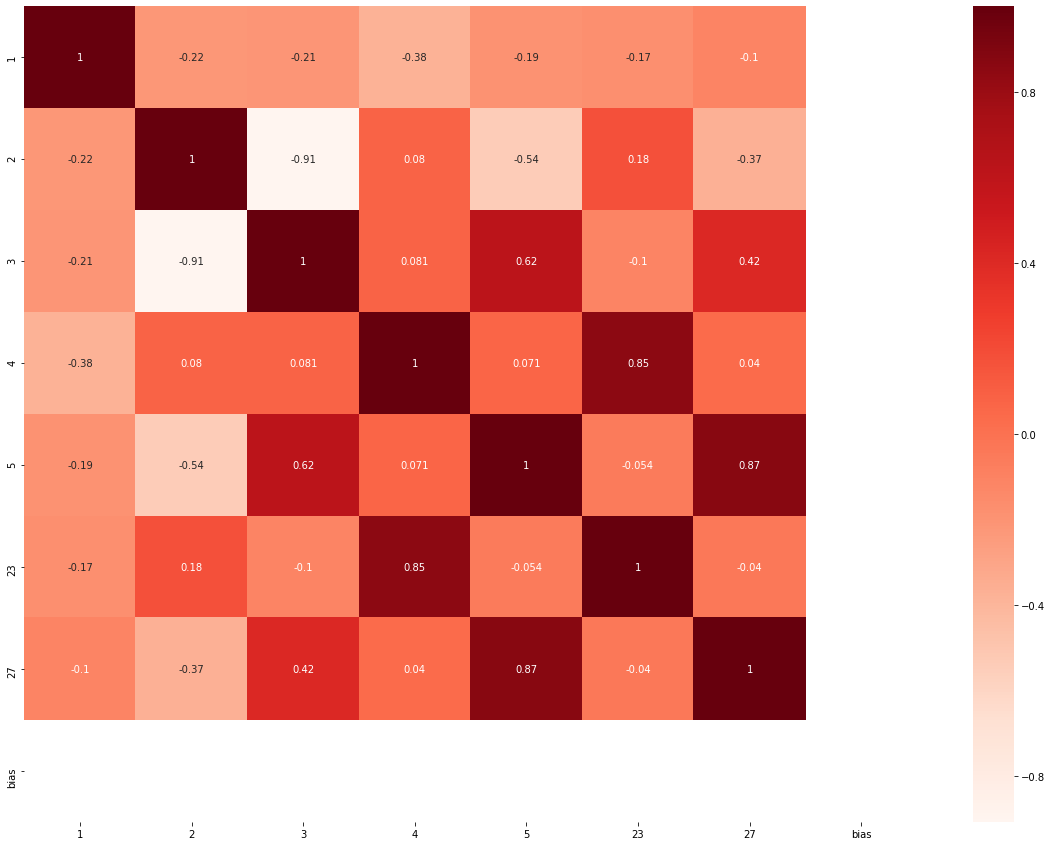

In [96]:
plt.figure(figsize=(20,15))
corr = train_X.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

Визуализируем признаки, включим целевую переменную, чтобы легче было дать интерпретацию признакам

In [97]:
data = train_X[[1,2,3,4,5,23,27]]
data['y'] = train_Y[0]

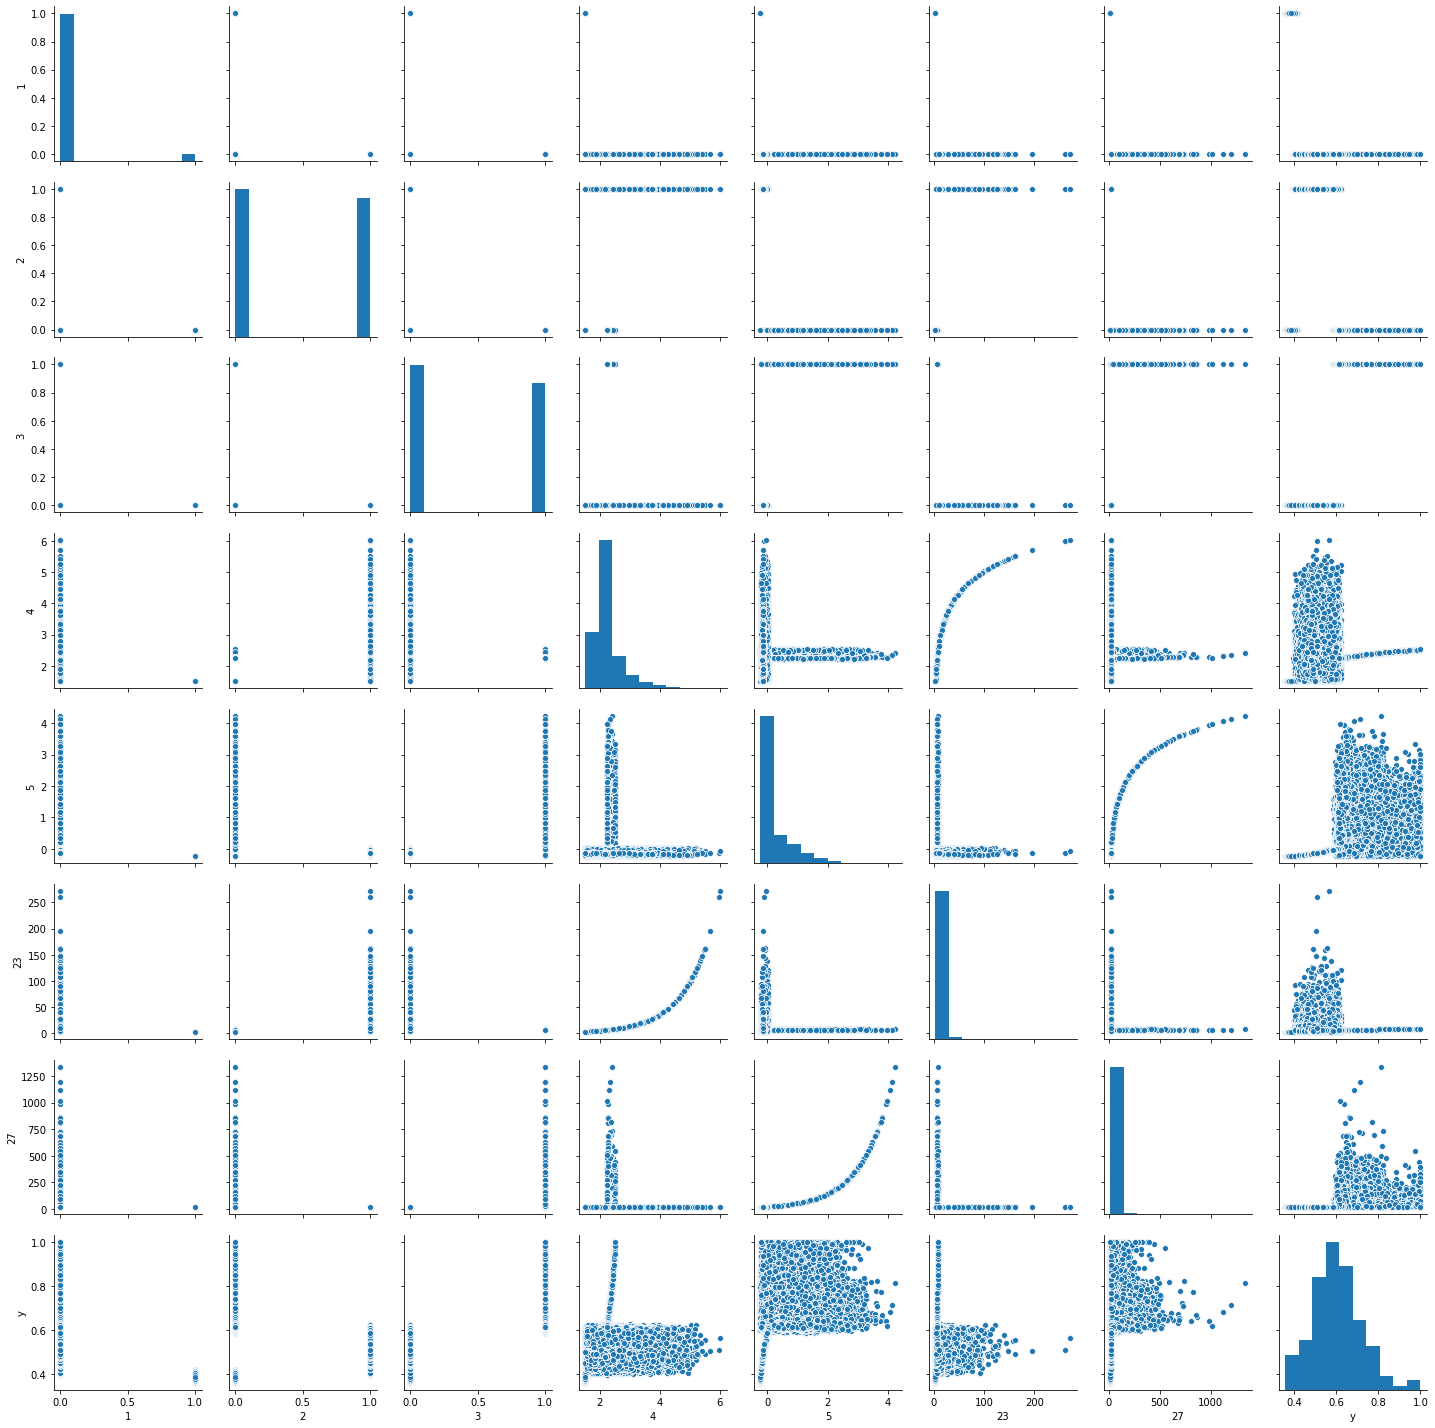

In [98]:
_ = sns.pairplot(data)

Признаки 23 и 27 явно зависят от 4 и 5, выкинем их 

In [99]:
data.drop(columns = [23,27], inplace = True)
train_X.drop(columns = [23,27], inplace = True)
test_X.drop(columns = [23,27], inplace = True)

/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


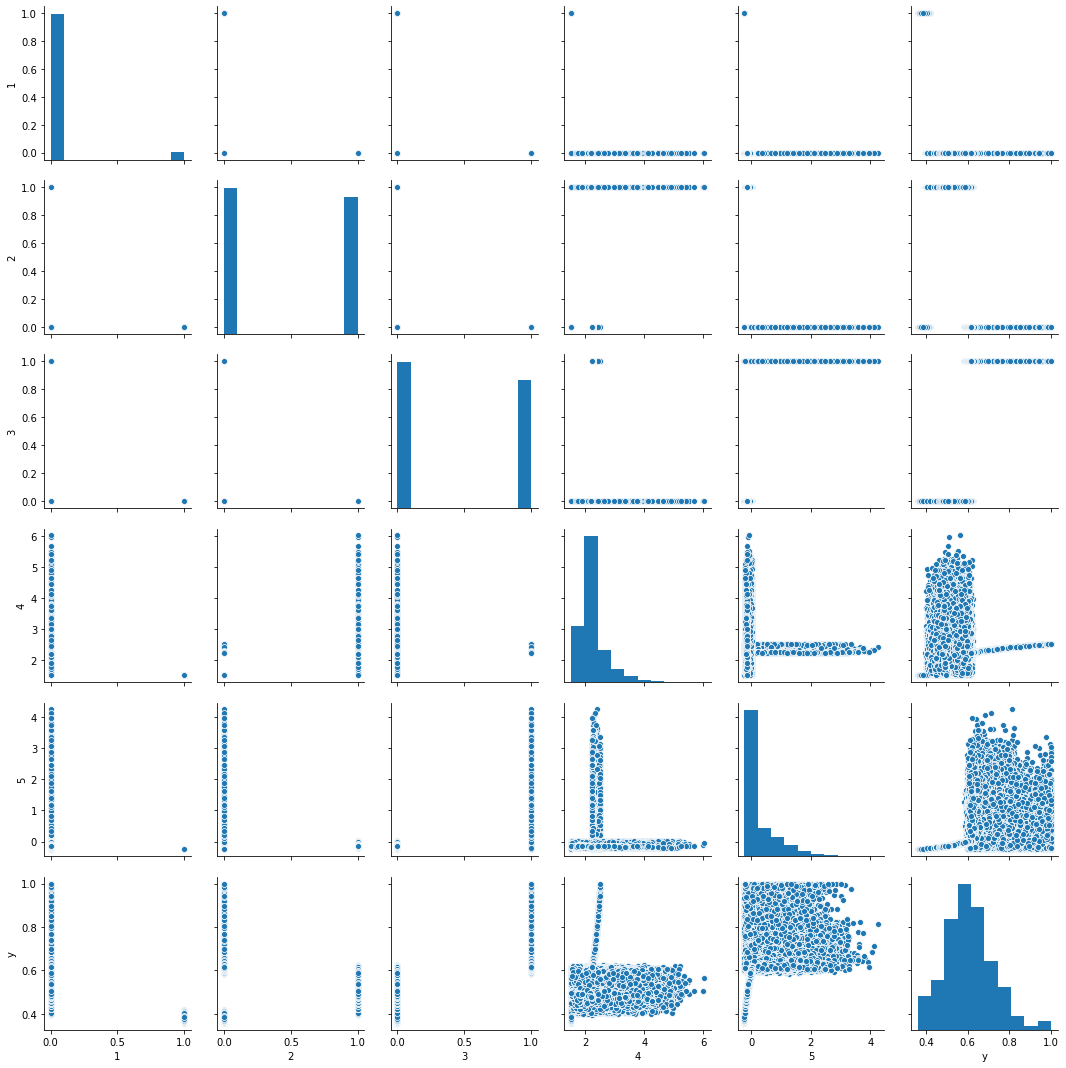

In [100]:
_ = sns.pairplot(data)

### Построим модель, учитывая всё вышенаписанное 

In [101]:
change = {column : 'feature_'+str(column) for column in data.columns if column != 'y'}
change['y'] = 'y'
data = data.rename(columns=change)

In [102]:
formula1 = ' '.join(['y ~', 
                    ' + '.join([f for f in data.columns[:-1]])])
formula1

'y ~ feature_1 + feature_2 + feature_3 + feature_4 + feature_5'

In [103]:
model1 = sm.OLS.from_formula(formula1, data=data).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                 9.121e+04
Date:                Fri, 15 May 2020   Prob (F-statistic):               0.00
Time:                        11:56:17   Log-Likelihood:             2.2475e+05
No. Observations:              172744   AIC:                        -4.495e+05
Df Residuals:                  172739   BIC:                        -4.494e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3821      0.001    624.276      0.000       0.381       0.383
feature_1     -0.0194      0.001    -34.702      0.000      -0.020      -0.018
feature_2      0.1203      0.000    306.881      0.000       0.120       0.121
feature_3      0.2812      0.000    647.033      0.000       0.280       0.282
feature_4      0.0142      0.000     37.909      0.000       0.014       0.015
feature_5      0.0087      0.000     22.774      0.000       0.008       0.009
==============================================================================
Omnibus:                    40932.087   Durbin-Watson:                   0.621
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           122965.281
Skew:                           1.229   Prob(JB):                         0.00
Kurtosis:                       6.322   Cond. No.                     1.92e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.21e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Не оч

Попробуем добавлять значимые межфакторные взаимодействия:

In [104]:
features = data.columns.tolist()[:-1]
for f1 in range(len(features)):
    for f2 in range(f1+1, len(features)): 
        f1_ = features[f1]
        f2_ = features[f2]
        model = sm.GLM.from_formula(formula1+'+'+str(f1_)+':'+str(f2_),
                                    data=data).fit()               
        for name, p in model.pvalues.items():
            if p<0.05 and ':' in name:
                print (f1_, f2_, model.bic)

/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/vitalijugnivenko/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


feature_1 feature_4 -2082407.712005789
feature_1 feature_5 -2082407.712005789
feature_2 feature_4 -2082934.7794176862
feature_2 feature_5 -2082588.0601937838
feature_3 feature_4 -2082934.7794176862
feature_3 feature_5 -2082588.0601937838
feature_4 feature_5 -2082595.6310459818


feature_2:feature_4 и feature_3:feature_4 можно попробовать

In [105]:
addition = 'feature_2:feature_4' + ' + ' 'feature_3:feature_4'
for_wald = 'feature_2:feature_4' + ' = ' 'feature_3:feature_4'

In [106]:
model2 = sm.OLS.from_formula(formula1+'+'+addition,
                                    data=data).fit() 
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                 3.483e+05
Date:                Fri, 15 May 2020   Prob (F-statistic):               0.00
Time:                        11:57:03   Log-Likelihood:             3.3444e+05
No. Observations:              172744   AIC:                        -6.689e+05
Df Residuals:                  172738   BIC:                        -6.688e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.4927      0.001   -363.718      0.000      -0.495      -0.490
feature_1               0.1426      0.000    476.808      0.000       0.142       0.143
feature_2               1.0286      0.001    741.875      0.000       1.026       1.031
feature_3              -1.6639      0.003   -568.290      0.000      -1.670      -1.658
feature_4               0.4823      0.001    650.886      0.000       0.481       0.484
feature_5               0.0088      0.000     43.403      0.000       0.008       0.009
feature_2:feature_4    -0.4825      0.001   -646.298      0.000      -0.484      -0.481
feature_3:feature_4     0.7477      0.001    670.495      0.000       0.746       0.750
==============================================================================
Omnibus:                    12408.200   Durbin-Watson:                   0.593
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19952.092
Skew:                          -0.566   Prob(JB):                         0.00
Kurtosis:                       4.221   Cond. No.                     3.47e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.36e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Проверим, есть ли смысл в добавлении этих межфакторных взаимодействий

In [107]:
model2.wald_test(for_wald+ ' = 0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[225148.06205827]]), p=0.0, df_denom=1.73e+05, df_num=2>

То есть в добавлении этих межфакторных взаимодействий есть смысл

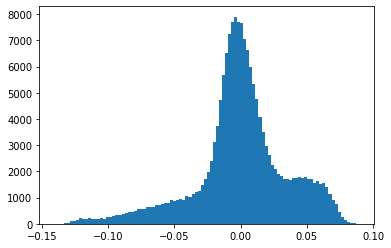

In [48]:
res = model2.resid
plt.hist(res, bins = 100)
plt.show()

Ошибка выглядит смещённо, надо ещё поработать

Добавим ещё два значимых 

In [109]:
addition = 'feature_2:feature_4' + ' + ' 'feature_3:feature_4' + ' + '  'feature_3:feature_5' + ' + ' 'feature_2:feature_5'
for_wald = 'feature_2:feature_4' + ' = ' 'feature_3:feature_4' + ' = ' 'feature_3:feature_5' + ' = ' 'feature_2:feature_5'

In [110]:
model3 = sm.OLS.from_formula(formula1+'+'+addition,
                                    data=data).fit() 
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 3.631e+06
Date:                Fri, 15 May 2020   Prob (F-statistic):               0.00
Time:                        11:59:24   Log-Likelihood:             5.4518e+05
No. Observations:              172744   AIC:                        -1.090e+06
Df Residuals:                  172737   BIC:                        -1.090e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.4644      0.000  -1158.929      0.000      -0.465      -0.464
feature_1               0.1569   8.81e-05   1781.457      0.000       0.157       0.157
feature_2               1.0659      0.000   2596.703      0.000       1.065       1.067
feature_3              -1.6872      0.001  -1951.818      0.000      -1.689      -1.685
feature_4               0.4896      0.000   2240.798      0.000       0.489       0.490
feature_5               0.2383      0.000   1285.850      0.000       0.238       0.239
feature_2:feature_4    -0.4896      0.000  -2223.974      0.000      -0.490      -0.489
feature_3:feature_4     0.7403      0.000   2246.468      0.000       0.740       0.741
feature_3:feature_5    -0.2383      0.000  -1262.158      0.000      -0.239      -0.238
feature_2:feature_5     0.5134      0.000   1380.141      0.000       0.513       0.514
==============================================================================
Omnibus:                    28509.516   Durbin-Watson:                   1.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            97130.865
Skew:                           0.829   Prob(JB):                         0.00
Kurtosis:                       6.278   Cond. No.                     2.39e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.89e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Ну теперь $r^2$ вообще по красоте

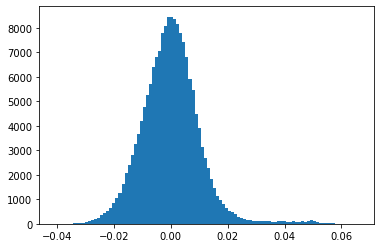

In [111]:
res = model3.resid
plt.hist(res, bins = 100)
plt.show()

И ошибка кайф

In [113]:
model3.wald_test(for_wald+ ' = 0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[1755690.3070821]]), p=0.0, df_denom=1.73e+05, df_num=4>

То есть в добавлении этих межфакторных взаимодействий есть смысл

Но вообще говоря, можно убрать один из признаков feature_1, feature_2, feature_3, так как они линейно зависимы - любой из них выражается через значения двух других

In [115]:
model4 = sm.OLS.from_formula('y ~ feature_2 + feature_3 + feature_4 + feature_5'+'+'+addition,
                                    data=data).fit() 
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 3.631e+06
Date:                Fri, 15 May 2020   Prob (F-statistic):               0.00
Time:                        12:08:04   Log-Likelihood:             5.4518e+05
No. Observations:              172744   AIC:                        -1.090e+06
Df Residuals:                  172737   BIC:                        -1.090e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.4179      0.000  -1094.826      0.000      -0.419      -0.417
feature_2               1.0194      0.000   2597.899      0.000       1.019       1.020
feature_3              -1.7337      0.001  -1958.932      0.000      -1.735      -1.732
feature_4               0.5605      0.000   2213.755      0.000       0.560       0.561
feature_5               0.2275      0.000   1231.171      0.000       0.227       0.228
feature_2:feature_4    -0.5604      0.000  -2208.075      0.000      -0.561      -0.560
feature_3:feature_4     0.6695      0.000   2210.828      0.000       0.669       0.670
feature_3:feature_5    -0.2274      0.000  -1207.246      0.000      -0.228      -0.227
feature_2:feature_5     0.5242      0.000   1405.593      0.000       0.524       0.525
==============================================================================
Omnibus:                    28509.516   Durbin-Watson:                   1.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            97130.865
Skew:                           0.829   Prob(JB):                         0.00
Kurtosis:                       6.278   Cond. No.                     1.11e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.35e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Почти ничего не поменялось, но признаков меньше - хорошо)

# Итоговая картинка

In [119]:
change = {column : 'feature_'+str(column) for column in test_X.columns if column != 'bias'}
change['bias'] = 'bias'
test_X = test_X.rename(columns=change)

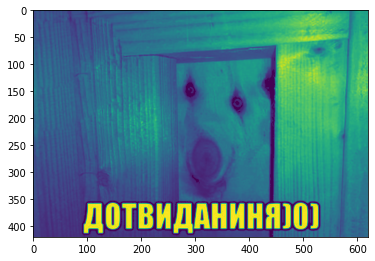

In [121]:
prediction = model4.predict(test_X)
test_Y = np.reshape(prediction.values, (-1, invert_dim2))
fig, ax = plt.subplots()

ax.imshow(test_Y)

fig.set_figwidth(6)   
fig.set_figheight(6)    

plt.show()

# Интерпретация признаков  

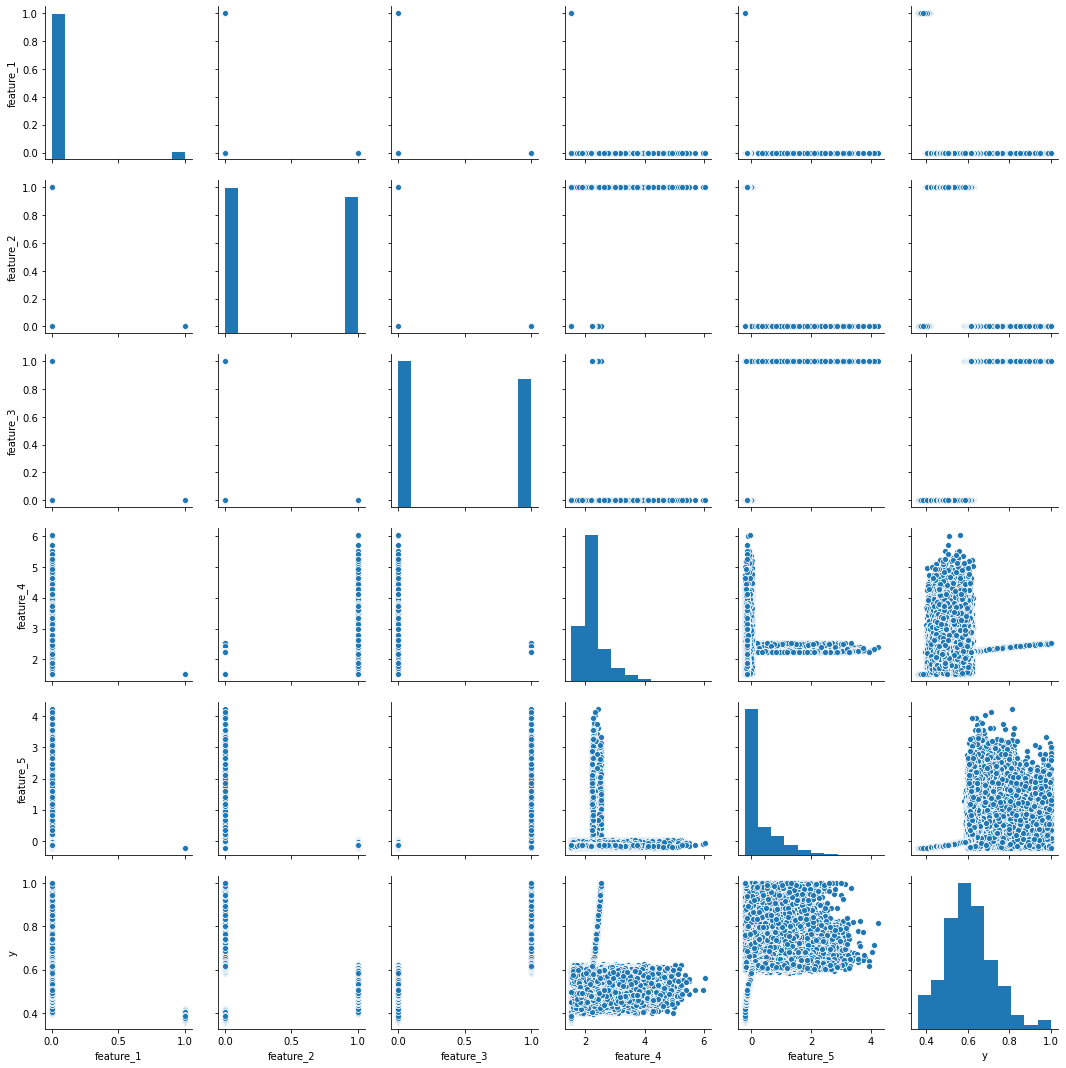

In [122]:
_ = sns.pairplot(data)

Ну признаки feature_1, feature_2 и feature_3 - явно острые сигмоиды (ступеньки) от целевой переменной. 
Обычно сигмоиды нужны при насыщениях чего-то, в нашем случае, видидмо, каждая отвечает за интенсивность цвета, например rgb.

Признаки feature_4, feature_5 друг друга дополняют до равномерной засветки (и явно видна какая-то прямая). Тут один из них что-то типа - контраснтности. Мы даём всем точкам равномерную (может контрастность или ещё что), а некоторым большую, чем другим. А второй из них наоборот противоположность этой контрастнотси, мб яркость. Возможно мы хотим этими признаками сильно выделить жёлтую надпись. 

# Попробуем готовую функцию для отбора признаков методом Stepwise, просто интересно, могёт ли эта штука что-то

In [58]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression

clf = LinearRegression()
regression_x_train = np.load('regression/regression_x_train.npy')
regression_y_train = np.load('regression/regression_y_train.npy')
regression_x_test = np.load('regression/regression_x_test.npy')
regression_x_train = np.reshape(regression_x_train,
                                (regression_x_train.shape[0]*regression_x_train.shape[1],
                                 regression_x_train.shape[2]))
regression_y_train = np.reshape(regression_y_train,
                                (regression_y_train.shape[0]*regression_y_train.shape[1],
                                ))
regression_x_test = np.reshape(regression_x_test,
                                (regression_x_test.shape[0]*regression_x_test.shape[1],
                                 regression_x_test.shape[2]))
train_X = pd.DataFrame(regression_x_train, columns = [i for i in range(1,36)])
test_X = pd.DataFrame(regression_x_test, columns = [i for i in range(1,36)])
train_Y = pd.DataFrame(regression_y_train)


# Build step forward feature selection
sfs1 = sfs(clf,k_features = 5,forward=True,floating=False, scoring='r2',cv=5)
# Perform SFFS
sfs1 = sfs1.fit(train_X, train_Y)

In [59]:
sfs1.subsets_

{1: {'feature_idx': (2,),
  'cv_scores': array([0.50212215, 0.53073611, 0.51612594, 0.48889829, 0.41817035]),
  'avg_score': 0.4912105663526661,
  'feature_names': (3,)},
 2: {'feature_idx': (2, 12),
  'cv_scores': array([0.54936894, 0.59441941, 0.58697553, 0.54472358, 0.61021763]),
  'avg_score': 0.5771410200474477,
  'feature_names': (3, 13)},
 3: {'feature_idx': (2, 3, 12),
  'cv_scores': array([0.55468545, 0.59961865, 0.58898788, 0.54111251, 0.61349452]),
  'avg_score': 0.5795798030373295,
  'feature_names': (3, 4, 13)},
 4: {'feature_idx': (2, 3, 12, 23),
  'cv_scores': array([0.55737577, 0.60222752, 0.5884482 , 0.53994978, 0.61517472]),
  'avg_score': 0.5806351987808125,
  'feature_names': (3, 4, 13, 24)},
 5: {'feature_idx': (2, 3, 4, 12, 23),
  'cv_scores': array([0.55757515, 0.6020733 , 0.588416  , 0.54344277, 0.61653118]),
  'avg_score': 0.5816076784488386,
  'feature_names': (3, 4, 5, 13, 24)}}

In [63]:
important_train_X = train_X[[3, 4, 5, 13, 24]]
model5 = OLS(train_Y ,important_train_X).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      0   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                          2.104e+06
Date:                Fri, 15 May 2020   Prob (F-statistic):                        0.00
Time:                        11:34:21   Log-Likelihood:                      1.9486e+05
No. Observations:              172744   AIC:                                 -3.897e+05
Df Residuals:                  172739   BIC:                                 -3.897e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
3              0.1712      0.000    343.901      0.000       0.170       0.172
4              0.2140      0.000    500.367      0.000       0.213       0.215
5             -0.0013      0.000     -2.887      0.004      -0.002      -0.000
13             0.0004   1.48e-05     26.459      0.000       0.000       0.000
24            -0.0006   2.57e-06   -229.828      0.000      -0.001      -0.001
==============================================================================
Omnibus:                    66892.542   Durbin-Watson:                   1.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1511732.754
Skew:                           1.336   Prob(JB):                         0.00
Kurtosis:                      17.244   Cond. No.                         670.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Кстаит, круто справилась

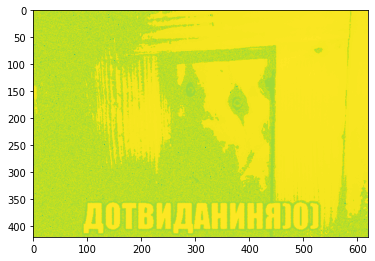

In [64]:
importnat_test_X = test_X[[3, 4, 5, 13, 24]]
prediction = model5.predict(importnat_test_X)
test_Y = np.reshape(prediction.values, (-1, invert_dim2))
fig, ax = plt.subplots()

ax.imshow(test_Y)

fig.set_figwidth(6)   
fig.set_figheight(6)    

plt.show()

Но картинка так себе, если честно, лучше тюнить своими руками!)